In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.vision.gan import *
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress
import torch
import argparse
from models.utils.joiner2 import GAN
from models.utils.losses import *
from models.utils.metrics import *
from models.utils.misc import *
from models.unet import UNet

from torchvision import datasets, transforms, models
import torchvision.transforms as T

In [2]:
H = 320
W= 320
bs = 5

seed = 1234

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

path = untar_data(URLs.IMAGENETTE_320)

In [3]:
transforms = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(H,W),
                 batch_tfms=transforms)

dloader = data.dataloaders(path,bs=bs,device='cuda') 

In [4]:
len(dloader.valid)

536

In [6]:
#dloader.show_batch()

In [5]:
generator_loss = GeneratorLossWrapper(3)
critic_loss = CriticLossWrapper(2)

gan = GAN(num_encoder_layers = 4, nhead=4, backbone = True, num_classes = 100, bypass=False, hidden_dim=256, 
          batch_size=bs, image_h=H, image_w=W,grid_l=4,penalty_factor="2")

In [6]:
critic_learn = Learner(dloader, gan, loss_func=critic_loss, metrics=[Accuracy, Critic_Attention_loss])
generator_learn = Learner(dloader, gan, loss_func=generator_loss, metrics=[Generator_Attention_loss, Adversarial_loss, Reconstruction_Loss])

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.0012022644514217973)

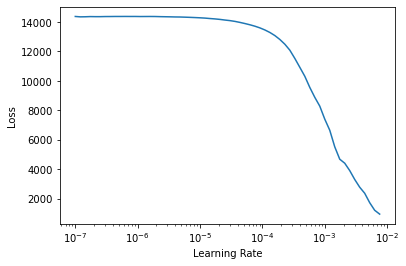

In [7]:
generator_learn.lr_find()

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.0008317637839354575)

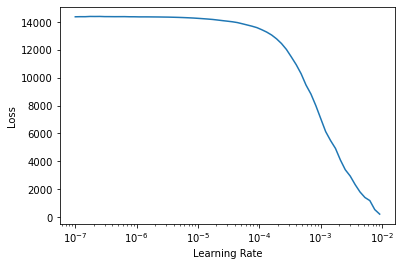

In [8]:
critic_learn.lr_find()

In [16]:
epochs = 1
for e in range(epochs):
    print("Epoch", e+1)
    print("Generator training")
    #Generator Training
    for param in gan.generator.parameters():
        param.requires_grad = True
    for param in gan.model.parameters():
        param.requires_grad = False
    gan.noise_mode = True
    
    generator_learn.fit_one_cycle(1,0.001)
    
    print("Critit training without noised images")
    #Critit training without noised images
    for param in gan.generator.parameters():
        param.requires_grad = False
    fb = ["mask","penalty_mask","pos"]
    for name, p in gan.model.named_parameters(): 
        if name not in fb:
            p.requires_grad_(True)
    gan.noise_mode = False
    critic_learn.fit(1,2e-6)
    print("Critit training with noised images")
    #Critit training with noised images
    gan.noise_mode = True
    critic_learn.fit(1,2e-6)

Epoch 1
Generator training


epoch,train_loss,valid_loss,Generator_Attention_loss,Adversarial_loss,Reconstruction_Loss,time
0,0.003602,0.003609,0.004079,-0.000047,0.000003,04:16


Critit training without noised images


epoch,train_loss,valid_loss,Accuracy,Critic_Attention_loss,time
0,2.053770,1.921795,0.354742,-0.004104,03:06


Critit training with noised images


epoch,train_loss,valid_loss,Accuracy,Critic_Attention_loss,time
0,1.788953,1.758235,0.409261,-0.004131,03:29
